In [67]:
import os
import pickle
import jieba
import json
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

font_path = '../msjh.ttc'
font = font_manager.FontProperties(fname='../msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

In [9]:
jieba.set_dictionary('../jieba_data/dict.txt.big')

# Add some politician and political words(combination of names.txt and events.txt)
jieba.load_userdict('../jieba_data/userdict.txt')

# Read stopwords from stopwords.txt into a list(some words which we don't want to count in dictionary)
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

stopwords[:10]

Building prefix dict from /Users/lou/Desktop/Political-News-Analysis/jieba_data/dict.txt.big ...
Loading model from cache /var/folders/9s/g05f34pj357c2472cct2h0j00000gn/T/jieba.uaa03fac251389d553a9128e6cd897ec2.cache
Loading model cost 1.051 seconds.
Prefix dict has been built succesfully.


['\ufeff', '', '$', '0', '1', '2', '3', '4', '5', '6']

In [18]:
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1]
# just load the content of data
contents = [news['content'] for news in data]

In [8]:
# Politicians
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')

# Political words(e.g. news)
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [27]:
def remove_punctuation(content_string, user_pc=False):
    if(user_pc):
        punctuation = user_pc
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for p in punctuation:
        content_string = content_string.replace(p, " ")
    return(content_string)

def remove_stopwords_from_dict(word_dict, stopwords):
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict

def lcut_to_dict(lcut):
    # count the frequency of lcut
    word_dict = dict(Counter(lcut))
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))

def sort_dict_by_values(d):
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))


In [16]:
# for every news in news_list, get the news which contain keyword
def news_containing_keyword(keyword, news_list):
    return list(filter(lambda news: keyword in news, news_list))

def data_containing_keyword(keyword, data):
    return list(filter(lambda news: keyword in news['cutted_dict'].keys(), data))

def news_containing_keywords(keywords, news_list):
    news = news_list
    for keyword in keywords:
        news = news_containing_keyword(keyword, news)
        
    return news

In [20]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content)) # return a list(lcut)
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

## Coshow

In [36]:
def get_coshow(content):
    coshow_dict = {}
    # Use " " to combine the first 100 contents to a string
    cat_content = ' '.join(contents[:100])
    clean_content = remove_punctuation(cat_content)
    cut_content = jieba.lcut(clean_content)
    cut_content = list(filter(lambda x: x!=' ', cut_content)) # filter " " from cut_content
    for i in range(len(cut_content)-1):
        # consider the continuous string(length is 2, there may be some wrong cut) 
        wcw = cut_content[i] + cut_content[i+1]
    #     print(wcw)
        # Use try and except to deal with the existence of keyword of dictionary
        try:
            coshow_dict[wcw] = coshow_dict[wcw] + 1
        except:
            coshow_dict[wcw] = 1

    sdbv = sort_dict_by_values(coshow_dict)
    return sdbv

In [37]:
# # output possible words to txt
# import codecs
# list_sdbv = [x[0] for x in sdbv]
# with codecs.open('t.txt', 'w', 'utf-8') as f:
#     f.write('\n'.join(list_sdbv))

## Count words

In [38]:
def get_cutted_dict(list_of_news):
    cat = ' '.join(list_of_news)
    cat = remove_punctuation(cat)
    cutted = jieba.lcut(cat)
    return lcut_to_dict(cutted)

# limit the length of words
def first_n_words(cutted_dict, n, word_len=2, to=1000):
    sdbv = sort_dict_by_values(cutted_dict)
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n]

In [39]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1624),
 ('中國', 919),
 ('柯文哲', 884),
 ('國民黨', 847),
 ('民進黨', 654),
 ('指出', 578),
 ('希望', 551),
 ('媒體', 534),
 ('蔡英文', 474),
 ('政府', 459),
 ('政策', 436),
 ('支持', 433),
 ('一個', 428),
 ('提供', 416),
 ('未來', 411),
 ('姚文智', 397),
 ('市長', 395),
 ('活動', 392),
 ('國家', 385),
 ('選舉', 373)]

In [40]:
# All content
cutted_dict = get_cutted_dict(contents)

#### 以下做法不知是否會有corner case
1. 陳菊
2. 學運

In [41]:
# 可能人名(用限制要取word的長度來做到此事)
possible_name = first_n_words(cutted_dict, 1000, 3, 3)

In [42]:
# 可能事件（四字以上的event）
possible_events = first_n_words(cutted_dict, 200, 4)

## Wordcloud

In [68]:
wc = WordCloud(max_font_size=40,
               background_color="white",
               colormap='Set2',
               font_path=font_path,   # watch out for the current pwd
               width=1000, height=300,
              max_words=1000)

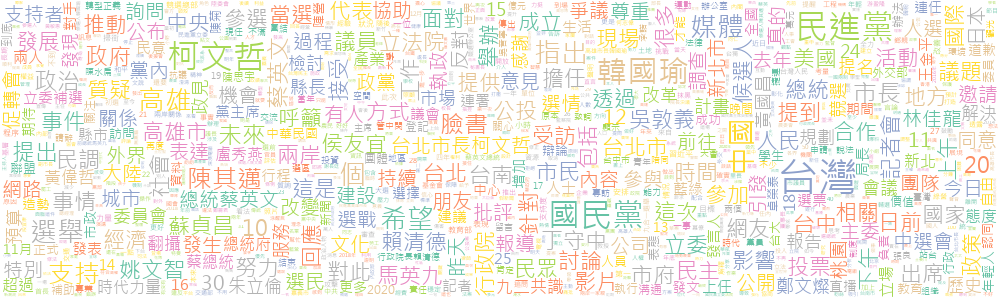

In [69]:
# cutted_dict = get_cutted_dict(contents)
high_freq_pair = first_n_words(cutted_dict, 10000)

# Transform list to dictionary and generate the wordcloud
wc.generate_from_frequencies({word: freq for (word, freq) in high_freq_pair}).to_image()

In [63]:
def get_wordcloud_of_keywords(keywords, list_of_news, image_path=False):
    if type(keywords) == str:
        keywords = [keywords]
    
    # check whether there is the shape of wordcloud
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring)
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else:
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       colormap='Set2',
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keywords, list_of_news)
    keyword_dict = get_cutted_dict(keyword_news)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict)
    return im

## 熱門政治人物文字雲

49866


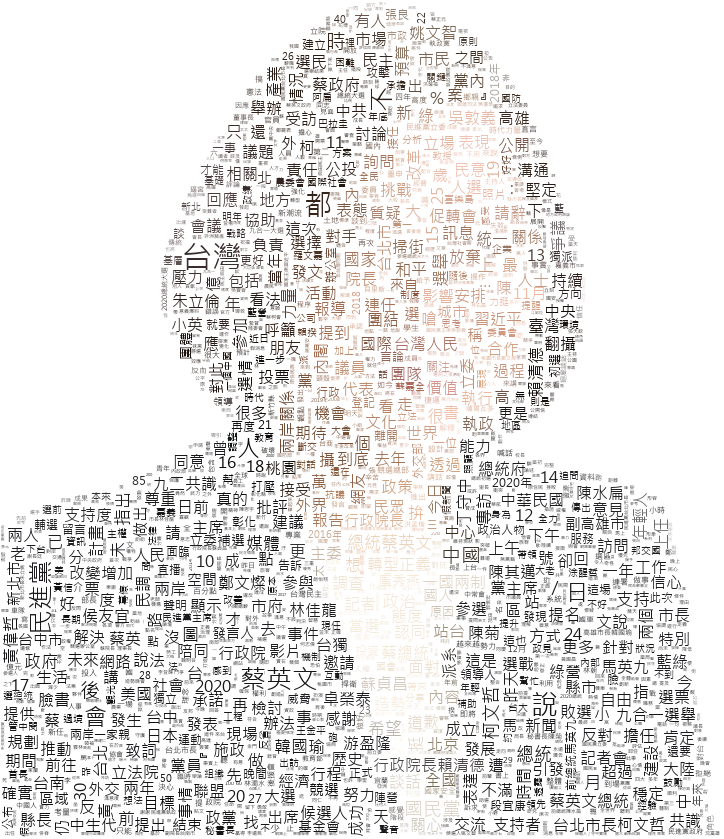

In [64]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
ten_wc.to_file('../politicians/tenwc.png')
ten_wc.to_image()

In [70]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 10)

[('台灣', 5121),
 ('蔡英文', 4043),
 ('民進黨', 3692),
 ('中國', 2211),
 ('國民黨', 2018),
 ('柯文哲', 1894),
 ('總統', 1880),
 ('支持', 1568),
 ('一個', 1468),
 ('總統蔡英文', 1411)]

42597


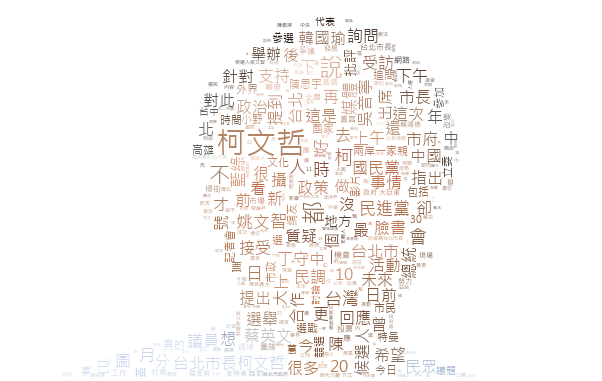

In [29]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
kp_wc.to_file('../politicians/kpwc.png')
kp_wc.to_image()

In [30]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 10)

[('柯文哲', 8153),
 ('媒體', 2356),
 ('姚文智', 2120),
 ('台灣', 2117),
 ('民進黨', 2107),
 ('丁守中', 1822),
 ('選舉', 1703),
 ('台北市長柯文哲', 1590),
 ('市長', 1538),
 ('國民黨', 1469)]

43755


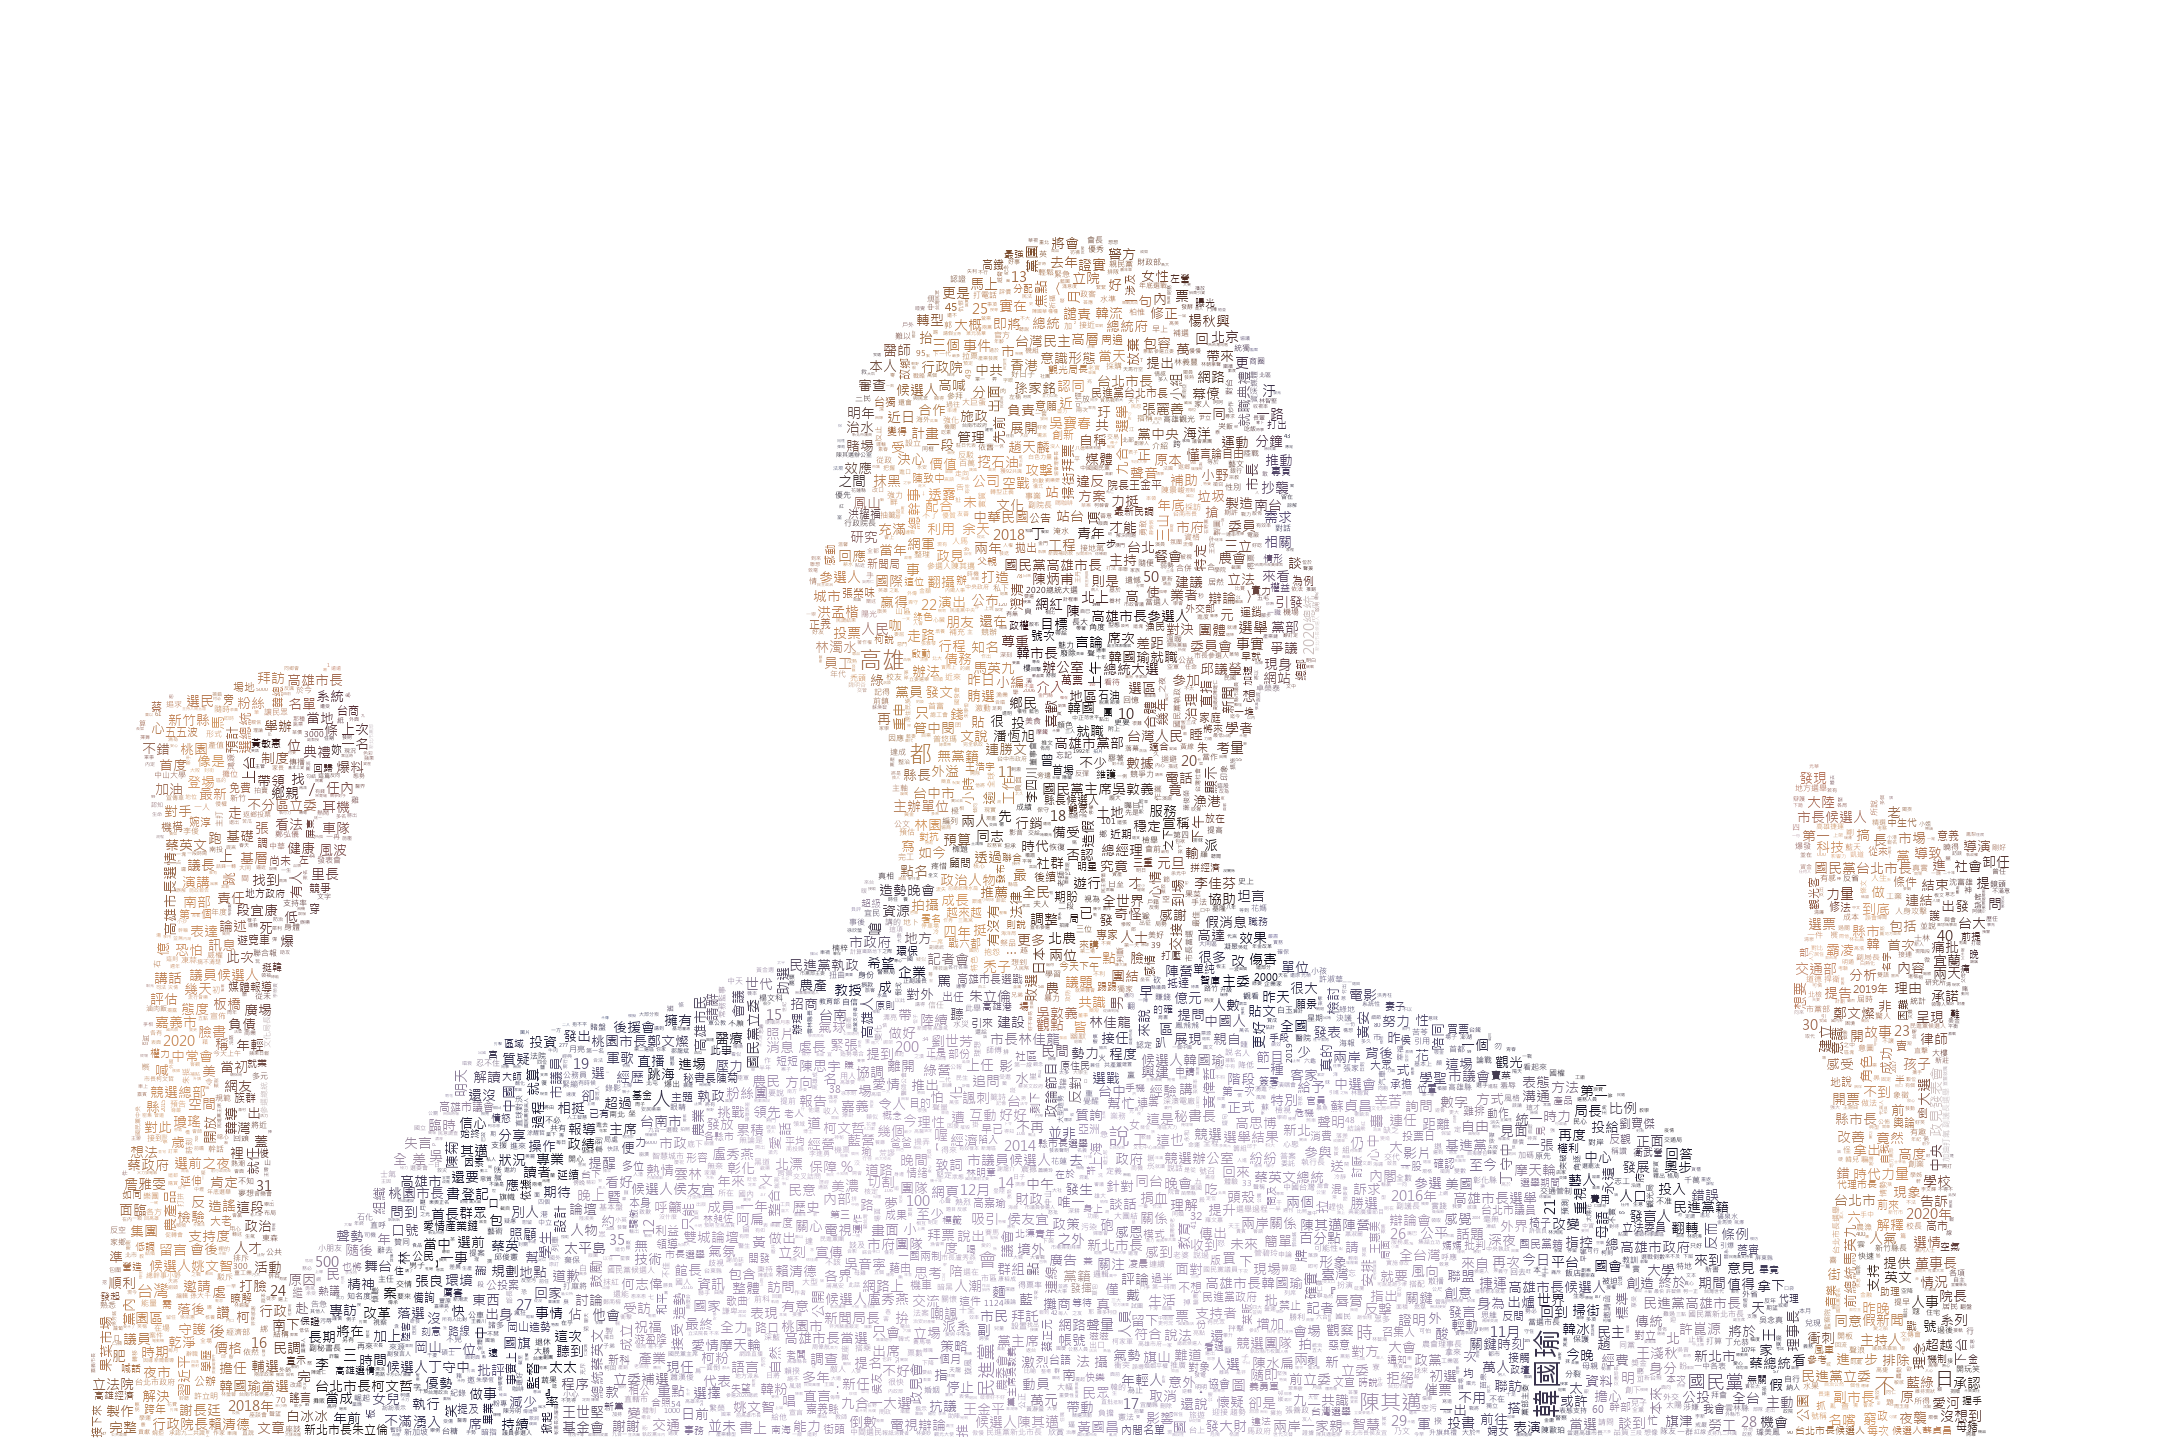

In [31]:
# 韓國瑜
han_wc = get_wordcloud_of_keywords('韓國瑜', contents, '../politicians/han.png')
han_wc.to_file('../politicians/hanwc.png')
han_wc.to_image()

In [32]:
news_containing_han = news_containing_keyword('韓國瑜', contents)
han_dict = get_cutted_dict(news_containing_han)
first_n_words(han_dict, 10)

[('韓國瑜', 6590),
 ('高雄', 3259),
 ('陳其邁', 2644),
 ('國民黨', 2065),
 ('民進黨', 1740),
 ('台灣', 1518),
 ('選舉', 1304),
 ('柯文哲', 1166),
 ('網友', 1138),
 ('媒體', 1036)]

18666


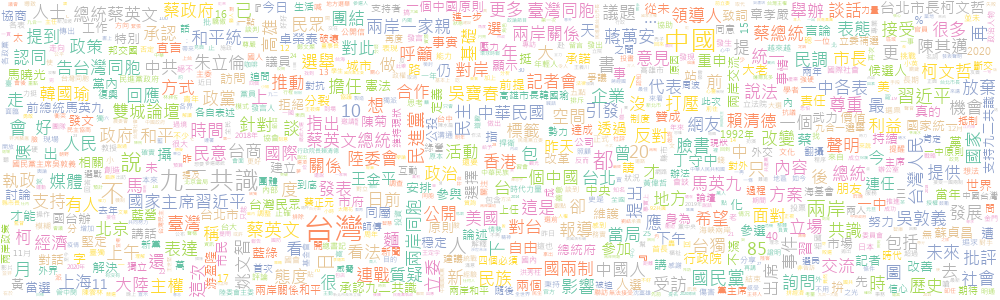

In [34]:
# 九二共識
nt_wc = get_wordcloud_of_keywords('九二共識', contents)
nt_wc.to_file('../politicians/92.png')
nt_wc.to_image()

In [35]:
hot = '九二共識'
news_containing_hot = news_containing_keywords(hot, contents)
hot_dict = get_cutted_dict(news_containing_hot)
first_n_words(hot_dict, 10, 3) # 人名

[('九二共識', 1022),
 ('國民黨', 611),
 ('民進黨', 549),
 ('蔡英文', 483),
 ('習近平', 467),
 ('柯文哲', 400),
 ('韓國瑜', 392),
 ('馬英九', 319),
 ('一國兩制', 301),
 ('吳寶春', 287)]

1303


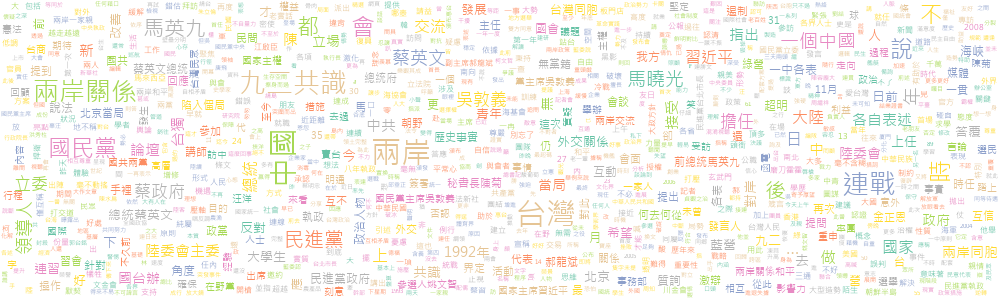

In [36]:
hotwc = get_wordcloud_of_keywords([hot, '蔡英文'], contents[:1000])
hotwc.to_image()

In [37]:
hotP = news_containing_keywords([hot, '蔡英文'], contents)
hotP_dict = get_cutted_dict(hotP)
first_n_words(hotP_dict, 10, 2)

[('台灣', 952),
 ('中國', 739),
 ('九二共識', 655),
 ('蔡英文', 467),
 ('民進黨', 357),
 ('兩岸', 353),
 ('習近平', 337),
 ('國民黨', 286),
 ('一國兩制', 231),
 ('接受', 206)]

In [38]:
# coloring
# pic_path = 'politicians/kp.png'
# kp_coloring = np.array(Image.open(os.path.join(pic_path)))
# kp_coloring_func = ImageColorGenerator(kp_coloring)

# kpwc = WordCloud(max_font_size=30,
#                background_color="white",
#                mask=kp_coloring,
#                color_func=kp_coloring_func,
#                font_path=font_path,
#                width=1000, height=1000)

## defining events

In [92]:
# Because there are many news in one day, we want to consider all word occr or frenquency in one day
def merge_one_day_news_dict(one_day_dict, count='wt', divide = 1):
    all_words = set([word for each_dict in one_day_dict for word in each_dict])
    one_day_wf = {}
    for word in all_words:
        one_day_wf[word] = 0
        for news in one_day_dict:
            if count == 'wt':
                one_day_wf[word] += news.get(word, 0)/divide
            if count == 'occur':
                one_day_wf[word] += bool(news.get(word, 0))/divide
    
    return one_day_wf

In [72]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list))) # every date just appear once
aall_date = [date[5:] for date in all_date] # Remove year
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
# 斷詞詞數
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [94]:
# 每日詞數
wn_by_day = {}

# 每日詞頻
tf_by_day = {}

# 每天出現的字
occur_by_day = {}

for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
    wn_by_day[all_date[i]] = merge_one_day_news_dict(oneday_dict)
    tf_by_day[all_date[i]] = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
    occur_by_day[all_date[i]] = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])

In [95]:
def first_n_wf_by_day(wf_by_day, n, word_len=2, to=1000):
    return {day: dict(first_n_words(wf_by_day[day], n, word_len=word_len, to=to)) for day in wf_by_day}

In [97]:
first_10_wf_by_day = first_n_wf_by_day(tf_by_day, 10, 2)
first_5_wf_by_day = first_n_wf_by_day(tf_by_day, 5, 2)

In [100]:
df1 = pd.DataFrame(first_10_wf_by_day)
df2 = pd.DataFrame(first_5_wf_by_day)

In [101]:
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)

In [102]:
df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

In [103]:
df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

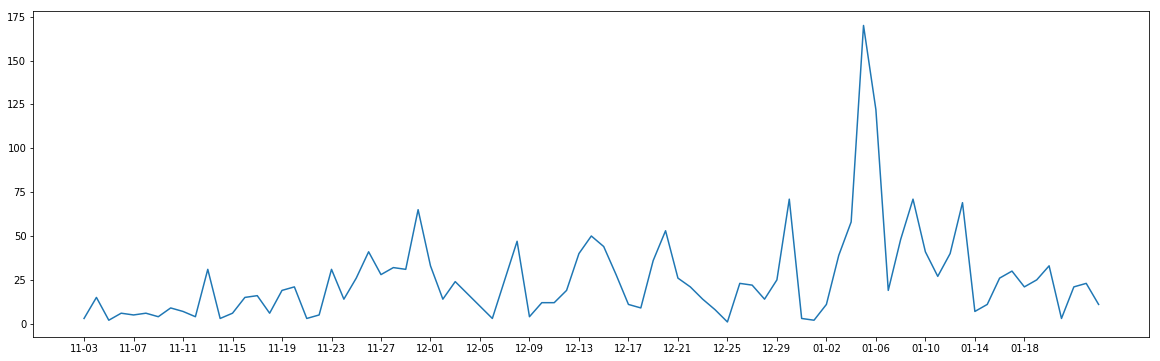

In [51]:
# word times
plt.figure(figsize=(20,6))
plt.plot(aall_date[147:], df.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.show()

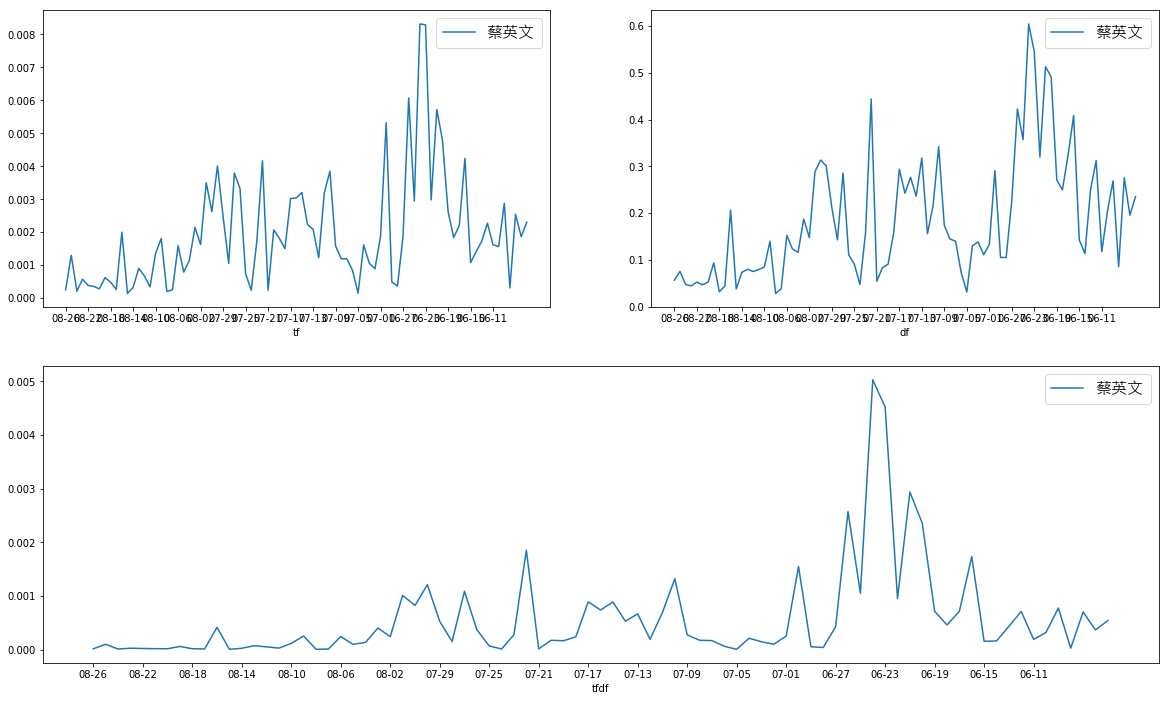

In [67]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(212)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

In [68]:
def plot_line_of_word(word, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], df.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])
    
def plot_tfdf_of_word(word, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])


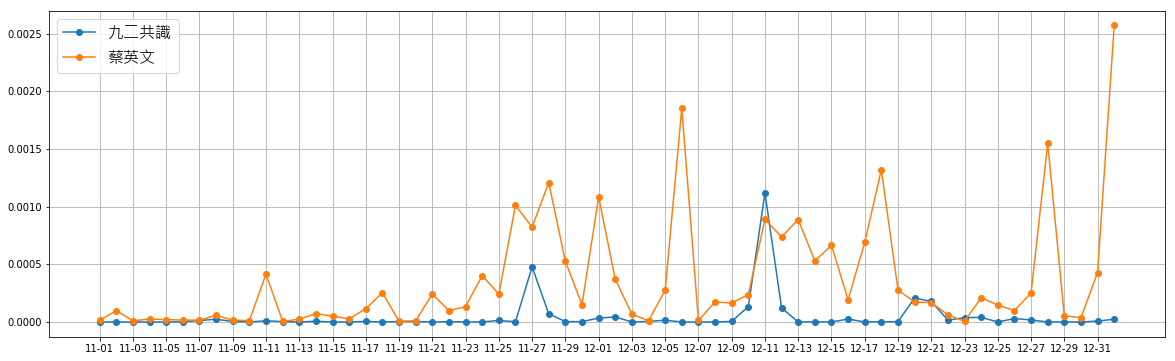

In [69]:
plt.figure(figsize=(20,6))
# plot_line_of_word('九二共識', date_from='2018-11-01', date_to='2019-01-01')
# plot_line_of_word('蔡英文', date_from='2018-11-01', date_to='2019-01-01')

plot_tfdf_of_word('九二共識', date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

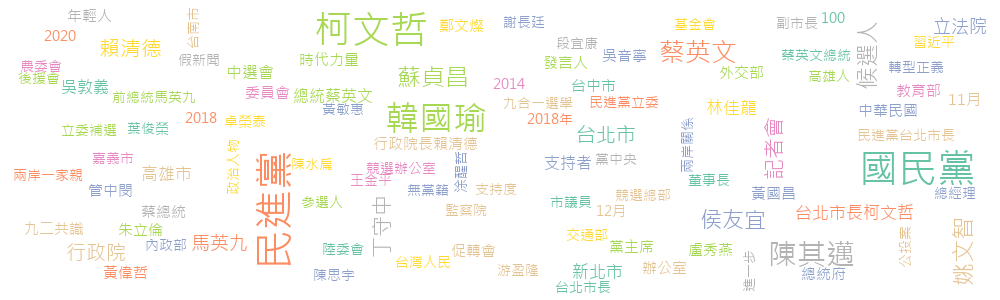

In [70]:
hot3 = first_n_words(cutted_dict, 100, 3)
hot3l = [x[0] for x in hot3]
wc.generate_from_frequencies(dict(hot3)).to_image()

In [71]:
def get_tfdf(word):
    tfdf = df_occur.loc[word] * df_tf.loc[word]
    return tfdf

In [72]:
def get_high_tfdf_date(word):
    tfdf = df_occur.loc[word] * df_tf.loc[word]
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf]
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    return tfdf_date

In [73]:
hot3 = [x[0] for x in first_n_words(cutted_dict, 100, 3, 3)]
hot3
hot3_date = {word: get_high_tfdf_date(word) for word in hot3}

In [75]:
def keyword_with_event(keyword):
    news_containing_key = news_containing_keyword(keyword, contents)
    key_dict = get_cutted_dict(news_containing_key)
    key_term = first_n_words(key_dict, 300)
    return list(filter(lambda x: x in hot4, [x[0] for x in key_term]))


In [76]:
def draw_event(event, i):
    event_date = get_high_tfdf_date(event)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])
    
def draw_by_list(tf_list, i):
    plt.scatter(aall_date, [i for x in aall_date], s=[x*10 for x in tf_list])

In [77]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e) for e in events}

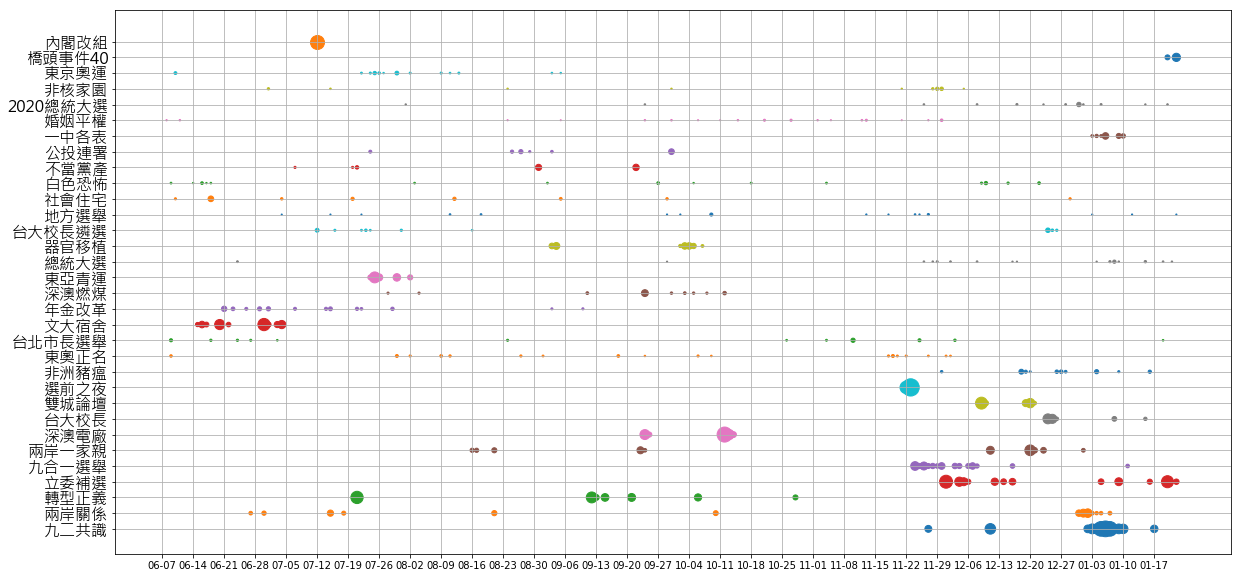

In [78]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [82]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
with open('event_people_dict.json', 'w', encoding='utf-8') as j:
    json.dump(event_people_dict, j)

九二共識


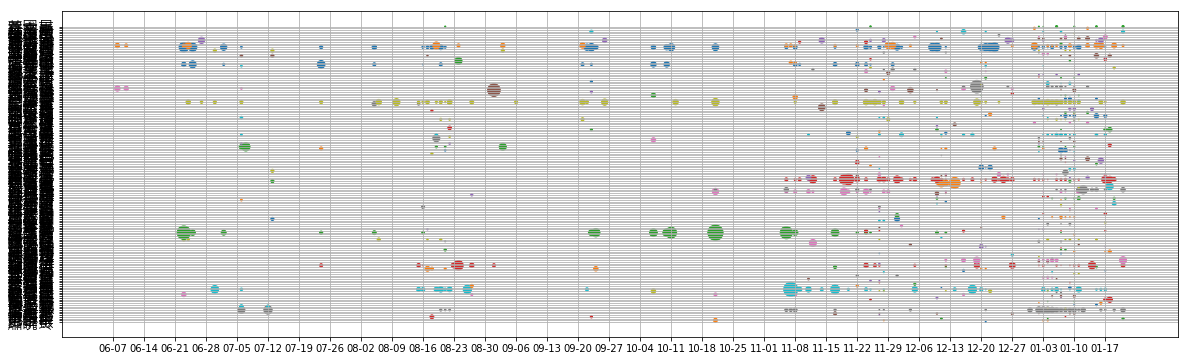

In [106]:
# event_people_dict = dict(sorted(event_people_dict.items(), key=lambda x: sum(x[1]), reverse=True)[:10])

plt.figure(figsize=(20, 6))

event = list(event_people_dict.keys())[0]
print(event)
for (i, people) in enumerate(event_people_dict[event]):
    draw_by_list(event_people_dict[event][people], i)

plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, len(event_people_dict[event])), [people for people in event_people_dict[event]], fontproperties=font)
    
plt.grid()
plt.show()

In [107]:
people_tfdf_dict = {name: list(get_tfdf(name)) for name in names}
# with open('people_tfdf_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(people_tfdf_dict, j)

In [108]:
font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

ratio = tfdf_ratio(word)
plt.figure(figsize=(20, 6))
plot_tfdf_of_word(word)
plt.grid()
a = [x*0.00001 for x in ratio]
plt.plot(aall_date, a)
plt.scatter(peak_date, [-0.0005 for i in range(len(peak_date))], c='r')
plt.scatter(tfdf_date, [-0.0003 for i in range(len(tfdf_date))], c='y')
plt.plot(aall_date, [m+s for i in aall_date], 'r-', label='m+s')
plt.plot(aall_date, [0.00005 for i in aall_date], 'g-', label='ratio threshold')

plt.ylim((-0.001, 0.003))
plt.legend(prop=font)
plt.show()

NameError: name 'tfdf_ratio' is not defined

## TFIDF

In [315]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [325]:
ccontents = [remove_punctuation(news) for news in contents]

In [326]:
corpus = [' '.join(jieba.lcut(news)) for news in ccontents]

In [327]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
word = vectorizer.get_feature_names()

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

In [328]:
pd.DataFrame(tfidf.toarray(), columns=word)

00  000  0000  0001  0005030960009  001  0015  002  003  0039 ...   \
0      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
1      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
2      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
3      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
4      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
5      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
6      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
7      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
8      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
9      0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
11     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
12     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
13     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
14     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
15     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
16     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
17     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
18     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
19     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
20     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
21     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
22     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
23     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
24     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
25     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
26     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
27     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
28     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
29     0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
...    ...  ...   ...   ...            ...  ...   ...  ...  ...   ... ...    
10461  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10462  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10463  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10464  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10465  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10466  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10467  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10468  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10469  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10470  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10471  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10472  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10473  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10474  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10475  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10476  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10477  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10478  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10479  0.0  0.0   0.0   0.0            0.0  0.0   0.0  0.0  0.0   0.0 ...    
10480  0.0  0.0   0.0   0.0   